# Group Project 4

imports 

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os

read in EPA air_quality .csv files

In [3]:
# read in each CSV file in air_quality_data directory and concatenate them into one dataframe
air_quality_data = pd.concat([pd.read_csv('air_quality_data/{}'.format(file)) for file in os.listdir('air_quality_data')])

# life expectancy data by CA county
life_expectancy = pd.read_csv('health_data/Vital_Signs_Life_Expectancy_by_county.csv')

# mortality tables for CA counties from 2014-2022
mortality = pd.read_csv('health_data/mortality.csv')

Filter `air_quality_data` down to only California

In [37]:
# filter for only California 
ca_df = air_quality_data.query('State == "California"').copy()

# Set the index to be the year
ca_df.set_index('Year', inplace=True)

In [38]:
ca_df.head()

,State,County,Days with AQI,Good Days,Moderate Days,Unhealthy for Sensitive Groups Days,Unhealthy Days,Very Unhealthy Days,Hazardous Days,Max AQI,90th Percentile AQI,Median AQI,Days CO,Days NO2,Days Ozone,Days PM2.5,Days PM10
Year,,,,,,,,,,,,,,,,,
2012,California,Alameda,366,262,100,3,1,0,0,161,64,41,0,23,180,163,0
2012,California,Alpine,24,18,5,1,0,0,0,111,63,38,0,0,0,24,0
2012,California,Amador,363,257,86,19,1,0,0,156,90,40,0,0,363,0,0
2012,California,Butte,366,170,165,23,8,0,0,186,97,53,0,0,230,136,0
2012,California,Calaveras,366,245,108,12,1,0,0,156,87,44,0,0,281,84,1


<AxesSubplot:title={'center':'Unhealthy Days in California by Year'}, xlabel='Year'>

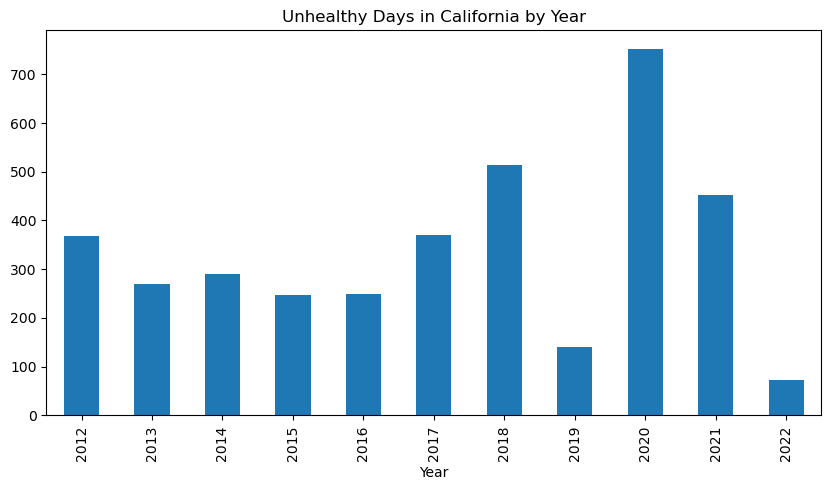

In [12]:
# aggregate Unheathy Days by year
unhealthy_days = ca_df.groupby('Year')['Unhealthy Days'].sum()

# plot the data
unhealthy_days.plot(kind='bar', figsize=(10, 5), title='Unhealthy Days in California by Year')

# CA Mortality Statistics

| Abbreviation | Cause of Death |
| --- | --- |
| ALL | All causes (total) |
| ALZ | Alzheimer's disease [G30] |
| CAN | Malignant neoplasms (cancers) [C00-C97] |
| CLD | Chronic lower respiratory disease (CLRD) [J40-J47] |
| DIA | Diabetes mellitus [E10-E14] |
| HOM | Assault (homicide) [*U01-*U02, X85-Y09, Y87.1] |
| HTD | Diseases of heart [I00-I09, I11, I13, I20-I51] |
| HYP | Essential hypertension and hypertensive renal disease [I10, I12, I15] |
| INJ | Accidents (unintentional injuries) [V01-X59, Y85-Y86] |
| LIV | Chronic liver disease and cirrhosis [K70, K73-K74] |
| NEP | Nephritis, nephrotic syndrome and nephrosis [N00-N07, N17-N19, N25-N27] |
| PAR | Parkinson's disease [G20-G21] |
| PNF | Pneumonia and influenza [J09-J18] |
| STK | Cerebrovascular disease (stroke) [I60-I69] |
| SUI | Intentional self-harm (suicide) [*U03, X60-X84, Y87.0] |


In [124]:
# deaths likely attributable to air pollution
respiratory_diseases = ['CLD', 'CAN', 'PNF', 'HTD']

In [127]:
def plot_air_quality_by_county(county, air_qual, diseases):
    """
    Plots the number of deaths from a specified set of diseases in a given county, 
    and the amount of specified air quality days in that county, on separate subplots.
    
    Args:
        county (str): The name of the county to plot data for.
        air_qual (str): The type of air quality to plot data for.
        diseases (list): A list of strings representing the names of the diseases to plot data for.
    """
    # create figure and subplots
    fig, ax = plt.subplots(2, 1, figsize=(10, 10))

    # query mortality df
    mortality.query(f'County == "{county}" and Strata == "Total Population" and Cause in {diseases}').groupby('Year')['Count'].sum().plot(kind='line', figsize=(10, 5), title=f'Deaths from Respiratory Diseases in {county} by Year', ax=ax[0])
    

    # overlay line plot of unhealthy days from ca_df log scale
    ca_df.query(f'County == "{county}"').groupby('Year')[air_qual].sum().plot(kind='line', figsize=(10, 5), title=f'{air_qual} in {county} by Year', ax=ax[1])

    # tight layout
    plt.tight_layout()

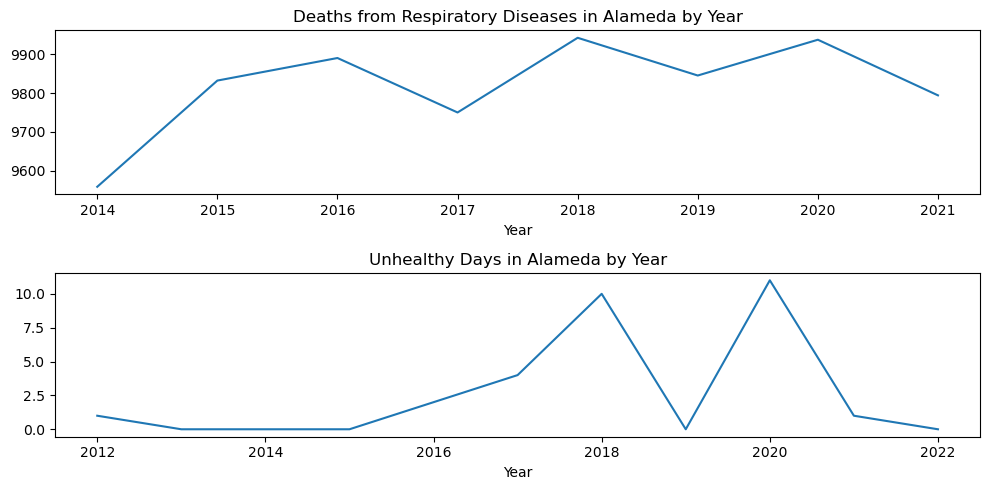

In [128]:
plot_air_quality_by_county('Alameda', 'Unhealthy Days', respiratory_diseases)